In [1]:
import io
from IPython.nbformat import current
def execute_notebook(nbfile):
    with io.open(nbfile) as f:
        nb = current.read(f, 'json')
    ip = get_ipython()
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)
execute_notebook("/cellar/users/ramarty/Projects/kir/KIR_development/bin/imports.ipynb")
execute_notebook("/cellar/users/ramarty/Projects/kir/KIR_development/data_gathering/alternate/sample_mapping.ipynb")

Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/IPython/nbformat/current.py:19: UserWarning: IPython.nbformat.current is deprecated.

- use IPython.nbformat for read/write/validate public API
- use IPython.nbformat.vX directly to composing notebooks of a particular version

  """)


In [2]:
# want the ordering of this to be the same...
df_whole = pd.concat([pd.read_csv('/cellar/users/ramarty/Data/kir/components/alternate/components_four_counts.csv', index_col=0),
                      pd.read_csv('/cellar/users/ramarty/Data/kir/components/tcga/components_four_counts.csv', index_col=0)])
df_whole = df_whole.ix[[x for x in df_whole.index if x not in sorta_low_coverage_patients]]

In [3]:
large_populations, size = [], []
for i, population in enumerate(population_dictionary.keys()):
    samples = population_dictionary_stripped[population]
    df_tmp = df_whole.ix[samples].dropna()
    if len(df_tmp) > population_size_cutoff:
        large_populations.append(population)
        size.append(len(df_tmp))
plotting_df = pd.DataFrame({'Population': large_populations,
                            'Size': size})
plotting_df = plotting_df.sort_values('Size', ascending=False)

In [4]:
plotting_df

,Population,Size
2,TCGA,1595
3,TCGA_agilent,668
4,2017_dbGap_phs000209.v13.p3_MESA,535
5,2017_dbGap_phs000179.v5.p2_GenEpidCOPD,200
6,2017_dbGap_phs000291.v2.p1_NHLBILungCOPD,193
0,2017_dbGap_phs000254.v2.p1_NHLBILungCF,168
7,2017_dbGap_phs000422.v1.p1_NHLBILungA,159
1,2017_dbGap_phs000632.v1.p1_NHLBIFamHC,136


In [5]:
def get_pop(x):
    for pop in plotting_df.Population:
        if x in population_dictionary_stripped[pop]:
            return pop
    return ''

In [6]:
def get_tissue(x):
    try:
        return list(tissue_df.ix[x])[0]
    except:
        return ''

In [7]:
def get_capture_kit(x):
    try:
        tissue = list(tissue_df.ix[x])[0]
        return exome_kit_dictionary[tissue]
    except:
        return ''

In [8]:
def unsupervised_clustering(df, learner, category):
    if learner == 'tsne':
        model = TSNE(n_components=2, random_state=0)
        TSNEs = model.fit_transform(df[four_mers])
    elif learner == 'pca':
        pca = PCA(n_components=2)
        TSNEs = pca.fit_transform(df)
    
    tsne_df = pd.DataFrame(TSNEs)
    tsne_df.columns = ['tsne1', 'tsne2']
    tsne_df['sample'] = df.index
    
    if category == 'population':
        tsne_df['population'] = tsne_df['sample'].apply(get_pop)
        tsne_df = tsne_df[tsne_df.population.isin(large_populations)]
        palette = sns.color_palette("hls", len(plotting_df.Population))
        colors = {}
        for i, population in enumerate(plotting_df.Population):
            colors[population] = palette[i]
        tsne_df['color'] = tsne_df.population.map(colors)
    elif category == 'tissue':
        tsne_df['tissue'] = tsne_df['sample'].apply(get_tissue)
        palette = sns.color_palette("hls", len(tsne_df['tissue'].unique()))
        colors = {}
        for i, tissue in enumerate(set(tsne_df.tissue)):
            colors[tissue] = palette[i]
        tsne_df['color'] = tsne_df.tissue.map(colors)
    elif category == 'capture_kit':
        tsne_df['capture_kit'] = tsne_df['sample'].apply(get_capture_kit)
        palette = sns.color_palette("hls", len(tsne_df['capture_kit'].unique()))
        colors = {}
        for i, capture_kit in enumerate(set(tsne_df.capture_kit)):
            colors[capture_kit] = palette[i]
        tsne_df['color'] = tsne_df.capture_kit.map(colors)
    
    plt.figure(figsize=(6,6))
    plt.scatter(tsne_df.tsne1, tsne_df.tsne2, c=tsne_df.color, lw = 0, alpha=0.5, s=20)
    
    return tsne_df

Combined population:

In [9]:
# should be based on frequencies instead of total counts
totals = df_whole[four_mers].sum(axis=1)
for mer in four_mers:
    df_whole[mer] = df_whole[mer] / totals

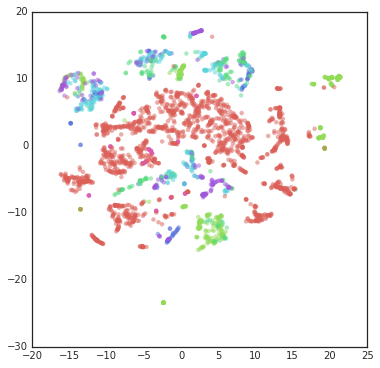

In [10]:
processed_df = unsupervised_clustering(df_whole[four_mers], 'tsne', 'population')

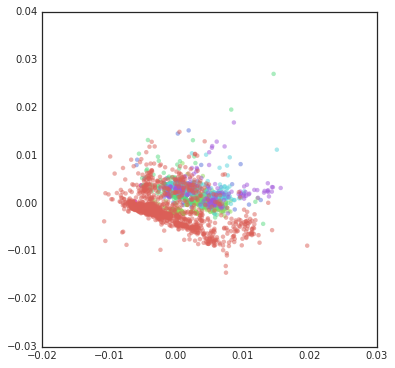

In [11]:
processed_df = unsupervised_clustering(df_whole[four_mers], 'pca', 'population')

In [12]:
cp = processed_df.drop_duplicates(['population', 'color'])
cp

,tsne1,tsne2,sample,population,color
0,0.000292,0.014585,SRR201052,2017_dbGap_phs000254.v2.p1_NHLBILungCF,"(0.34, 0.4388, 0.86)"
168,-0.005359,-0.001083,SRR1034682,2017_dbGap_phs000632.v1.p1_NHLBIFamHC,"(0.86, 0.34, 0.6988)"
284,0.005146,0.000596,SRR646695,2017_dbGap_phs000209.v13.p3_MESA,"(0.5688, 0.86, 0.34)"
673,0.003046,0.000969,SRR520540,2017_dbGap_phs000179.v5.p2_GenEpidCOPD,"(0.34, 0.86, 0.5012)"
962,0.004514,0.010165,SRR341741,2017_dbGap_phs000291.v2.p1_NHLBILungCOPD,"(0.34, 0.8288, 0.86)"
1155,0.014357,0.003400,SRR837145,2017_dbGap_phs000422.v1.p1_NHLBILungA,"(0.6312, 0.34, 0.86)"
1338,0.000330,0.002400,TCGA-HC-7737,TCGA,"(0.86, 0.3712, 0.34)"


['2017_dbGap_phs000254.v2.p1_NHLBILungCF',
 '2017_dbGap_phs000632.v1.p1_NHLBIFamHC',
 '2017_dbGap_phs000209.v13.p3_MESA',
 '2017_dbGap_phs000179.v5.p2_GenEpidCOPD',
 '2017_dbGap_phs000291.v2.p1_NHLBILungCOPD',
 '2017_dbGap_phs000422.v1.p1_NHLBILungA',
 'TCGA']

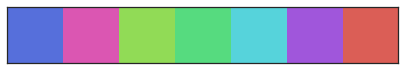

In [13]:
sns.palplot(cp.color, size=1)
list(cp.population)

TCGA population: 

In [14]:
df_tcga = pd.read_csv('/cellar/users/ramarty/Data/kir/components/tcga/components_four_counts.csv', index_col=0)

In [15]:
totals = df_tcga[four_mers].sum(axis=1)
for mer in four_mers:
    df_tcga[mer] = df_tcga[mer] / totals

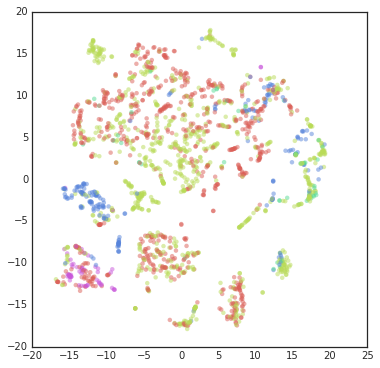

In [16]:
processed_df = unsupervised_clustering(df_tcga[four_mers], 'tsne', 'capture_kit')

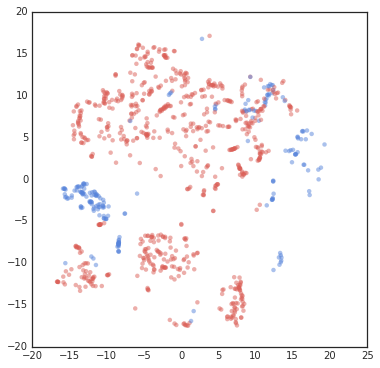

In [17]:
# try only plotting the known kits
reduced_processed_df = processed_df[processed_df.capture_kit.isin(['Agilent_50', 'NimbleGen_Var', 'Agilent_30'])]
plt.figure(figsize=(6,6))
plt.scatter(reduced_processed_df.tsne1, reduced_processed_df.tsne2, c=reduced_processed_df.color, lw = 0, alpha=0.5, s=20)


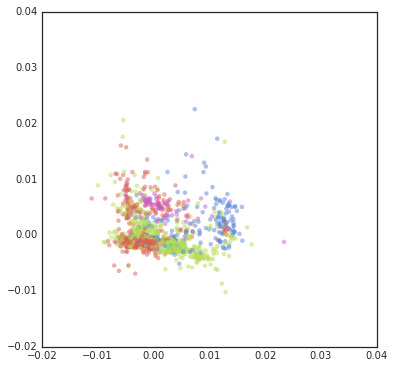

In [18]:
processed_df = unsupervised_clustering(df_tcga[four_mers], 'pca', 'capture_kit')

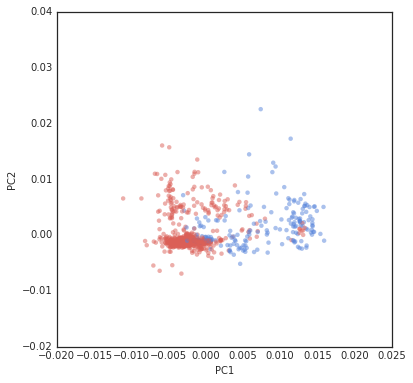

In [20]:
reduced_processed_df = processed_df[processed_df.capture_kit.isin(['Agilent_50', 'NimbleGen_Var', 'Agilent_30'])]
plt.figure(figsize=(6,6))
plt.scatter(reduced_processed_df.tsne1, reduced_processed_df.tsne2, c=reduced_processed_df.color, lw = 0, alpha=0.5, s=20)
plt.xlabel('PC1')
plt.ylabel('PC2')

In [72]:
reduced_processed_df.capture_kit.value_counts()

Agilent_50       173
NimbleGen_Var     49
Name: capture_kit, dtype: int64

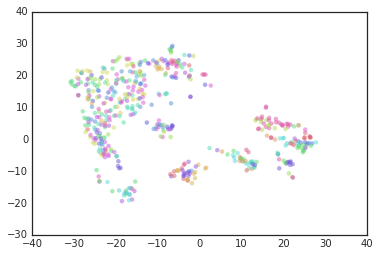

In [45]:
processed_df = unsupervised_clustering(df_tcga[four_mers], 'tsne', 'tissue')

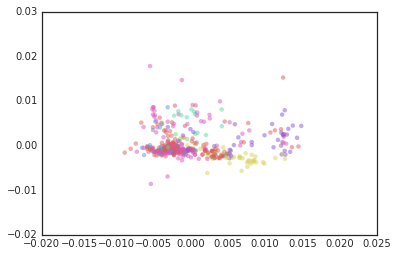

In [46]:
processed_df = unsupervised_clustering(df_tcga[four_mers], 'pca', 'capture_kit')